**Connect google drive**

In [1]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Thu May 20 15:37:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#!ln -s /content/gdrive/My\ Drive/ /mydrive
#!ls /mydrive

Mounted at /content/drive


**1) Clone the Darknet**



In [ ]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15046, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 15046 (delta 16), reused 25 (delta 10), pack-reused 15002
Receiving objects: 100% (15046/15046), 13.44 MiB | 23.25 MiB/s, done.
Resolving deltas: 100% (10214/10214), done.


**2) Compile Darknet using Nvidia GPU**


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make

/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:935:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1136:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
           

**3) Configure Darknet network for training YOLO V3**

In [ ]:
!cp cfg/yolov3.cfg cfg/yolov3_training.cfg

In [ ]:
!sed -i 's/batch=1/batch=64/' cfg/yolov3_training.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov3_training.cfg
!sed -i 's/max_batches = 500200/max_batches = 4000/' cfg/yolov3_training.cfg
!sed -i '610 s@classes=80@classes=1@' cfg/yolov3_training.cfg
!sed -i '696 s@classes=80@classes=1@' cfg/yolov3_training.cfg
!sed -i '783 s@classes=80@classes=1@' cfg/yolov3_training.cfg
!sed -i '603 s@filters=255@filters=18@' cfg/yolov3_training.cfg
!sed -i '689 s@filters=255@filters=18@' cfg/yolov3_training.cfg
!sed -i '776 s@filters=255@filters=18@' cfg/yolov3_training.cfg

In [ ]:
# Create folder on google drive so that we can save there the weights
!mkdir "/content/drive/MyDrive/yolov3"

In [ ]:
!echo "bienSo" > data/obj.names
!echo -e 'classes= 1\ntrain  = data/train.txt\nvalid  = data/test.txt\nnames = data/obj.names\nbackup = /content/drive/MyDrive/yolov3' > data/obj.data
!mkdir data/obj

mkdir: cannot create directory ‘data/obj’: File exists


In [ ]:
# Download weights darknet model 53
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2021-05-19 15:13:46--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  37.7MB/s    in 4.4s    

2021-05-19 15:13:51 (34.9 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



**4) Extract Images**

The images need to be inside a zip archive called "images.zip" and they need to be inside the folder "yolov3" on Google Drive

In [ ]:
!unzip /content/drive/MyDrive/yolov3/images.zip -d data/obj

In [ ]:
!unzip /content/drive/MyDrive/yolov3/test.zip -d data/obj

In [ ]:
import glob
import os
import re

txt_file_paths = glob.glob(r"/content/darknet/data/obj/Img_text/*.txt")
print(len(txt_file_paths))

877


In [ ]:
import glob
import os
import re

txt_file_paths = glob.glob(r"/content/darknet/data/obj/test/*.txt")
print(len(txt_file_paths))

37


In [ ]:
import glob
import os
import re
a = 0
txt_file_paths = glob.glob(r"/content/darknet/data/obj/Img_text/*.txt")

for i, file_path in enumerate(txt_file_paths):
    # get image size
    with open(file_path, "r") as f_o:
        lines = f_o.readlines()
        text_converted = []
        for line in lines:
            print(line)
            numbers = re.findall("[0-9.]+", line)
            print(numbers)
            print(a)
        a= a+1
        print("====================")

In [ ]:
import glob
import os
import re
a = 0
txt_file_paths = glob.glob(r"/content/darknet/data/obj/test/*.txt")

for i, file_path in enumerate(txt_file_paths):
    # get image size
    with open(file_path, "r") as f_o:
        lines = f_o.readlines()
        text_converted = []
        for line in lines:
            print(line)
            numbers = re.findall("[0-9.]+", line)
            print(numbers)
            print(a)
        a= a+1
        print("====================")

0 0.613000 0.883010 0.206000 0.081967

['0', '0.613000', '0.883010', '0.206000', '0.081967']
0
bienSo

[]
1
0 0.488125 0.640000 0.331250 0.337778

['0', '0.488125', '0.640000', '0.331250', '0.337778']
2
0 0.566667 0.649584 0.842424 0.529086

['0', '0.566667', '0.649584', '0.842424', '0.529086']
3
0 0.492920 0.648438 0.974121 0.317708

['0', '0.492920', '0.648438', '0.974121', '0.317708']
4
0 0.710623 0.489130 0.410256 0.326087

['0', '0.710623', '0.489130', '0.410256', '0.326087']
5
0 0.528986 0.601449 0.169082 0.079710

['0', '0.528986', '0.601449', '0.169082', '0.079710']
6
0 0.515833 0.726667 0.275000 0.088889

['0', '0.515833', '0.726667', '0.275000', '0.088889']
7
0 0.516250 0.777049 0.237500 0.088525

['0', '0.516250', '0.777049', '0.237500', '0.088525']
8
0 0.500000 0.675573 0.340000 0.103053

['0', '0.500000', '0.675573', '0.340000', '0.103053']
9
0 0.829167 0.796250 0.101667 0.072500

['0', '0.829167', '0.796250', '0.101667', '0.072500']
10
0 0.231982 0.794314 0.112613 0.04347

In [ ]:
# We're going to convert the class index on the .txt files. As we're working with only one class, it's supposed to be class 0.
# If the index is different from 0 then we're going to change it.
import glob
import os
import re

txt_file_paths = glob.glob(r"/content/darknet/data/obj/Img_text/*.txt")
print(enumerate(txt_file_paths))
for i, file_path in enumerate(txt_file_paths):
    # get image size
    with open(file_path, "r") as f_o:
        lines = f_o.readlines()
        text_converted = []
        for line in lines:
            print(line)
            numbers = re.findall("[0-9.]+", line)
            print(numbers)
            if numbers:
                # Define coordinates
                text = "{} {} {} {} {}".format(0, numbers[1], numbers[2], numbers[3], numbers[4])
                text_converted.append(text)
                print(i, file_path)
                print(text)
        # Write file
        with open(file_path, 'w') as fp:
            for item in text_converted:
                fp.writelines("%s\n" % item)

In [ ]:
import glob
import os
import re

txt_file_paths = glob.glob(r"/content/darknet/data/obj/test/*.txt")
print(enumerate(txt_file_paths))
for i, file_path in enumerate(txt_file_paths):
    # get image size
    with open(file_path, "r") as f_o:
        lines = f_o.readlines()
        text_converted = []
        for line in lines:
            print(line)
            numbers = re.findall("[0-9.]+", line)
            print(numbers)
            if numbers:
                # Define coordinates
                text = "{} {} {} {} {}".format(0, numbers[1], numbers[2], numbers[3], numbers[4])
                text_converted.append(text)
                print(i, file_path)
                print(text)
        # Write file
        with open(file_path, 'w') as fp:
            for item in text_converted:
                fp.writelines("%s\n" % item)

In [ ]:
import glob
images_list = glob.glob("/content/darknet/data/obj/Img_text/*.jpg")
print(images_list)

['/content/darknet/data/obj/Img_text/89.jpg', '/content/darknet/data/obj/Img_text/bien_so_xe_bac_kan.jpg', '/content/darknet/data/obj/Img_text/AQUA7_44039_checkin_2020-10-24-9-54Pd8mmXwMaw.jpg', '/content/darknet/data/obj/Img_text/AQUA5__checkout_2020-11-1-23-39UKDi0oUUl0.jpg', '/content/darknet/data/obj/Img_text/95.jpg', '/content/darknet/data/obj/Img_text/33.jpg', '/content/darknet/data/obj/Img_text/AQUA7_3555_checkin_2020-11-1-14-46Ab1b8Zf0ME.jpg', '/content/darknet/data/obj/Img_text/742159301.jpg', '/content/darknet/data/obj/Img_text/15.jpg', '/content/darknet/data/obj/Img_text/58.jpg', '/content/darknet/data/obj/Img_text/AQUA2__checkout_2020-10-29-9-58jy7Lae9GYD.jpg', '/content/darknet/data/obj/Img_text/27157.jpg', '/content/darknet/data/obj/Img_text/30.jpg', '/content/darknet/data/obj/Img_text/AQUA7_30A60434_checkin_2020-10-25-19-512gQoUFJeAl.jpg', '/content/darknet/data/obj/Img_text/AQUA5_26583_checkin_2020-11-1-14-47lnmPTO_6Z5.jpg', '/content/darknet/data/obj/Img_text/AQUA5_362

In [ ]:
import glob
images_list2 = glob.glob("/content/darknet/data/obj/test/*.jpg")
print(images_list2)

['/content/darknet/data/obj/test/unnamed.jpg', '/content/darknet/data/obj/test/bien-so-oto-co-co-wurth-1-2-600x567.jpg', '/content/darknet/data/obj/test/images (2).jpg', '/content/darknet/data/obj/test/JoqsjEKrFX.jpg', '/content/darknet/data/obj/test/bat-ngo-xuat-hien-2-o-to-chung-1-bien-so-dep-o-ha-noi.jpg', '/content/darknet/data/obj/test/485db5e02da0c4fe9db1-15728525077671243130220.jpg', '/content/darknet/data/obj/test/bien-so-xe-15-o-dau.jpg', '/content/darknet/data/obj/test/khung-bien-so-o-to-in-logo-quoc-ky-cao-cap-hang-dep-7-2.jpg', '/content/darknet/data/obj/test/ep-bien-co-chau-au003.jpg', '/content/darknet/data/obj/test/bien-so-dep.jpg', '/content/darknet/data/obj/test/biensoxe79odau_optimized.jpg', '/content/darknet/data/obj/test/bfc060f418ee57db8fc6bde2023d74c0.jpg', '/content/darknet/data/obj/test/bien-so-xe-cac-tinh-mien-bac.jpg', '/content/darknet/data/obj/test/dan-decal-doi-bien-so-o-to-3-xe-thanhnien_qqre.jpg', '/content/darknet/data/obj/test/cach-bam-bien-so-xe-dep.jp

In [ ]:
#Create training.txt file
file = open("data/train.txt", "w") 
file.write("\n".join(images_list)) 
file.close() 

In [ ]:
#Create training.txt file
file = open("data/test.txt", "w") 
file.write("\n".join(images_list2)) 
file.close()

**6) Start the training**

In [ ]:
# Start the training
!./darknet detector train data/obj.data cfg/yolov3_training.cfg darknet53.conv.74 -dont_show

^C


In [ ]:
!./darknet detector train data/obj.data cfg/yolov3_training.cfg /content/drive/MyDrive/yolov3/yolov3_training_last.weights -dont_show

In [ ]:
!./darknet detector valid /content/darknet/data/obj.data /content/drive/MyDrive/yolov3/yolov3_testing.cfg /content/drive/MyDrive/yolov3/yolov3_training_last.weights

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
results: Using default 'results'
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1

0
[[0]]


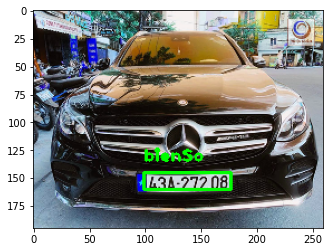

In [ ]:
import cv2
import numpy as np
import glob
import random
import matplotlib.pyplot as plt


# Load Yolo
net = cv2.dnn.readNet("/content/drive/MyDrive/yolov3/yolov3_training_last.weights", "/content/drive/MyDrive/yolov3/yolov3_testing.cfg")

# Name custom object
classes = ["bienSo"]

img = cv2.imread("/content/drive/MyDrive/yolov3/bien-so-o-to-mercedes-1.jpg")
img = cv2.resize(img, None, fx=0.4, fy=0.4)
height, width, channels = img.shape

# Detecting objects
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

net.setInput(blob)
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
outs = net.forward(output_layers)

    # Showing informations on the screen
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.3:
            # Object detected
            print(class_id)
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
print(indexes)
font = cv2.FONT_HERSHEY_PLAIN
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = (0, 255, 0)
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y - 10), font, 1, color, 2)
plt.imshow(img)
plt.show()

#cv2.show("Image", img)